# DST forecasting from OMNI data

This example shows how to use AIDApy to perform the following tasks:

* Download time series data from OMNI
* Preprocess the data so that it can be used for machine learning
* Train several models and evaluate their performance


## Downloading data

We will first download low-resolution data from [OMNI](https://omniweb.gsfc.nasa.gov/).


In [1]:
from datetime import datetime
from aidapy import load_data

# Set the start and end date as year, month, day
t0 = datetime(2005, 1, 1)
t1 = datetime(2015, 12, 31)

# Download the data
omnixr = load_data(mission='omni', start_time=t0, end_time=t1)

# Store data in pandas format
pd_data = omnixr['all1'].to_pandas()

pd_data.describe()

products,Rot$,IMF,PLS,IMF_PTS,PLS_PTS,ABS_B,F,THETA_AV,PHI_AV,BX_GSE,...,F10_INDEX,KP,DST,AE,AP_INDEX,AL_INDEX,AU_INDEX,PC_N_INDEX,Solar_Lyman_alpha,Proton_QI
count,96393.000000,96393.000000,96393.000000,96393.000000,96393.000000,96393.000000,96393.000000,96393.000000,96393.000000,96393.000000,...,96271.000000,96393.000000,96393.000000,96393.000000,96393.000000,96393.000000,96393.000000,96220.000000,96393.000000,95539.000000
mean,2413.760501,51.469121,52.429347,58.407623,34.630720,5.216569,4.620690,0.443720,200.816916,-0.003623,...,98.542885,15.653709,-10.433216,149.543712,8.207442,-93.390568,56.160862,0.876439,0.006932,0.020498
std,42.938091,3.026953,3.074889,7.630713,18.114134,2.785550,2.659933,29.517070,101.024027,3.079083,...,29.679565,12.689718,16.357846,177.953186,12.071763,128.297204,61.312473,1.171041,0.000782,0.035779
min,2339.000000,51.000000,51.000000,1.000000,1.000000,0.400000,0.100000,-89.199997,0.000000,-40.799999,...,65.099998,0.000000,-247.000000,3.000000,0.000000,-2452.000000,-225.000000,-6.900000,0.005880,0.000100
25%,2377.000000,51.000000,52.000000,58.000000,34.000000,3.400000,2.900000,-18.600000,121.099998,-2.200000,...,73.500000,7.000000,-17.000000,38.000000,3.000000,-120.000000,17.000000,0.100000,0.006252,0.008100
50%,2414.000000,51.000000,52.000000,60.000000,36.000000,4.600000,4.000000,0.100000,182.600006,0.000000,...,88.400002,13.000000,-8.000000,76.000000,5.000000,-38.000000,34.000000,0.600000,0.006697,0.013200
75%,2451.000000,51.000000,52.000000,61.000000,37.000000,6.200000,5.600000,19.200001,300.600006,2.200000,...,117.800003,23.000000,0.000000,192.000000,9.000000,-17.000000,72.000000,1.300000,0.007562,0.022500
max,2488.000000,71.000000,99.000000,91.000000,999.000000,55.400002,54.500000,89.800003,360.000000,26.400000,...,255.000000,87.000000,77.000000,2227.000000,300.000000,15.000000,873.000000,18.400000,0.009187,3.162000


Split the data into different sets
--

For evaluating the performance of a machine learning approach, the input data has to be split in different sets:

* A training set, on which the model is trained
* Optionally, a validation set, to tune so-called hyperparameters of the model
* A test set, which is only used at the end to evaluate the performance of the model

Such a separation is important to prevent [overfitting](https://en.wikipedia.org/wiki/Overfitting). Since there is usually a correlation between consecutive observations in a time series, it is important not to shuffle the data before splitting it in different sets. Otherwise, the test set would not be truly independent from the training set.


In [20]:
from sklearn.model_selection import train_test_split

# Split into training and test data
dtrain, dtest = train_test_split(pd_data, shuffle=False)

## Let's have a look at the data

Below, the DST index is shown. Note that there are quiet periods, and periods with more magnetic storms, indicated by large negative values.

<IPython.core.display.Javascript object>


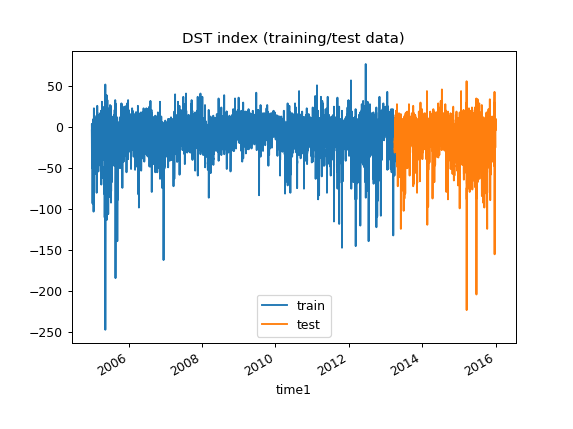

In [21]:
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
%matplotlib notebook
register_matplotlib_converters()

plt.figure()
plt.title("DST index (training/test data)")
dtrain['DST'].plot(label='train')
dtest['DST'].plot(label='test')
plt.gcf().autofmt_xdate()
plt.legend();

## Selecting features

The features are here selected by hand (and they are not necessarily the best ones).

In [22]:
pd_data.columns

Index(['Rot$', 'IMF', 'PLS', 'IMF_PTS', 'PLS_PTS', 'ABS_B', 'F', 'THETA_AV',
       'PHI_AV', 'BX_GSE', 'BY_GSE', 'BZ_GSE', 'BY_GSM', 'BZ_GSM',
       'SIGMA$ABS_B', 'SIGMA$B', 'SIGMA$Bx', 'SIGMA$By', 'SIGMA$Bz', 'T', 'N',
       'V', 'PHI$V', 'THETA$V', 'Ratio', 'Pressure', 'SIGMA$T', 'SIGMA$N',
       'SIGMA$V', 'SIGMA$PHI$V', 'SIGMA$THETA$V', 'SIGMA$ratio', 'E', 'Beta',
       'Mach_num', 'Mgs_mach_num', 'PR$FLX_1', 'PR$FLX_2', 'PR$FLX_4',
       'PR$FLX_10', 'PR$FLX_30', 'PR$FLX_60', 'MFLX', 'R', 'F10_INDEX', 'KP',
       'DST', 'AE', 'AP_INDEX', 'AL_INDEX', 'AU_INDEX', 'PC_N_INDEX',
       'Solar_Lyman_alpha', 'Proton_QI'],
      dtype='object', name='products')

In [23]:
features = ['ABS_B', 
            'F',
            'N',
            'T',
            'Mach_num',
            'BZ_GSM',
            'Ratio',
            'V',
            'Beta',
            'E',
            'DST']
targets = ['DST']

## Preprocessing data

The training and test data are preprocessed so that we can make predictions for the targets based on a history of the features. If the original features and targets are $X_i$ and $y_i$, then we define new features $X_i' = [X_i, X_{i-1}, \dots, X_{i-n-1}]$, where $n$ is the history size. We use these features to make predictions at some future time, so that the new targets are $y_i' = y_{i+k}$, where $k$ is the forecast time.

Another question is what to do with missing values. This is a common issue in working with space craft data -- in particular if data from multiple instruments is combined. We have opted for a simple approach: remove all samples for which some data is missing, either in the features or the targets.

In [24]:
from aidapy.ml import preprocess

histsize = 8                    # Number of past hours
forecast_time = 1               # Hours into the future

# Use the AIDApy preprocessing method for time series
X_train, y_train, mask_train = preprocess.time_series(
    dtrain[features].values, dtrain[targets].values, histsize, forecast_time)
X_test, y_test, mask_test = preprocess.time_series(
    dtest[features].values, dtest[targets].values, histsize, forecast_time)

t_train = dtrain.index[mask_train]
t_test = dtest.index[mask_test]

## Regression models

For the first use case, the following regression models are used:
* A fully-connected neural network implemented in PyTorch. Users can customize the number of layers, the number of neurons per layer, and the activation functions of the layers.
* A linear regression model imported from scikit-learn

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from aidapy.ml import mlp
from skorch import NeuralNetRegressor
import torch
from sklearn.neural_network import MLPRegressor

models = []

models.append({
    'name': 'Linear Regression',
    'pipe': Pipeline(steps=[('preprocess', StandardScaler()),
                            ('model', LinearRegression())])
})

# RegressorMlp is a simple, fully-connected neural network, 
# for which the layer sizes are defined below. The default
# activation function is ReLU.
mlp_model = NeuralNetRegressor(
    mlp.RegressorMlp,
    max_epochs=25,
    lr=0.001,
    batch_size=128,
    optimizer=torch.optim.Adam,
    module__layer_sizes=[X_train.shape[1], 64, 64, 64, 1]
)

mlp_model = MLPRegressor(hidden_layer_sizes=(64,64,64), batch_size=128, learning_rate_init=0.001,
                    max_iter = 30, random_state=1234, verbose=True)

models.append({
    'name': 'Multilayer perceptron',
    'pipe': Pipeline(steps=[('preprocess', StandardScaler()),
                            ('model', mlp_model)])
})

In [28]:
from sklearn.metrics import r2_score

for model in models:
    model['pipe'].fit(X_train, y_train)
    model['test_predict'] = model['pipe'].predict(X_test)
    model['train_predict'] = model['pipe'].predict(X_train)
    
for model in models:
    print("{:30} R2 score on test / train set:  {:8.3f} {:8.3f}".format(
        model['name'], r2_score(y_test, model['test_predict']),
        r2_score(y_train, model['train_predict'])))

/home/rdupuis/miniconda3/envs/notebooks_aidapy/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Iteration 1, loss = 20.46818287
Iteration 2, loss = 5.96428514
Iteration 3, loss = 4.98611478
Iteration 4, loss = 4.61998209
Iteration 5, loss = 4.41283720
Iteration 6, loss = 4.26267383
Iteration 7, loss = 4.19758459
Iteration 8, loss = 4.09795442
Iteration 9, loss = 4.07268872
Iteration 10, loss = 4.04450790
Iteration 11, loss = 3.99370556
Iteration 12, loss = 3.91256267
Iteration 13, loss = 3.86907777
Iteration 14, loss = 3.83515552
Iteration 15, loss = 3.82331413
Iteration 16, loss = 3.79208284
Iteration 17, loss = 3.73235991
Iteration 18, loss = 3.70226993
Iteration 19, loss = 3.70868946
Iteration 20, loss = 3.64979528
Iteration 21, loss = 3.63671652
Iteration 22, loss = 3.66141111
Iteration 23, loss = 3.66232610
Iteration 24, loss = 3.64099678
Iteration 25, loss = 3.58090160
Iteration 26, loss = 3.57182113
Iteration 27, loss = 3.54127049
Iteration 28, loss = 3.52931375
Iteration 29, loss = 3.44665343
Iteration 30, loss = 3.45464552
Linear Regression              R2 score on test 

/home/rdupuis/miniconda3/envs/notebooks_aidapy/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Let's compare the predictions with the actual data

<IPython.core.display.Javascript object>


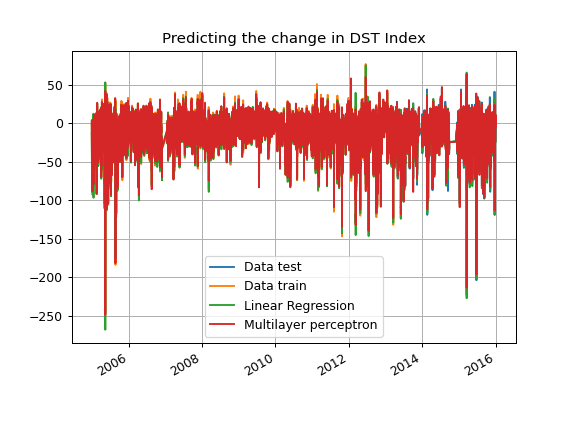

In [29]:
plt.figure()
plt.title('Predicting the change in DST Index')
plt.plot(t_test, y_test, label='Data test')
plt.plot(t_train, y_train, label='Data train')
for model in models:
    p = plt.plot(t_test, model['test_predict'], label=model['name'])
    # Plot another line with the same color
    plt.plot(t_train, model['train_predict'], color=p[0].get_color())
plt.legend()
plt.gcf().autofmt_xdate()
plt.grid(True)

## This looks pretty good, but...

Most variables we consider in a time series have strong auto-correlation. This means that future values strongly resemble past values; examples are the temperature at a location on earth or the price of a stock on a stock market. When making predictions for a variable with strong auto-correlation, one has to be careful in assessing the predictive power of a model. Simply predicting the past state as the future state can look convincing (also numerically in most error norms), but gives little information. 

Below, we therefore take the following approach: predict the change in the variable.

In [30]:
from aidapy.ml import preprocess

histsize = 24                   # Number of past hours
forecast_time = 1               # Hours into the future

# Use the AIDApy preprocessing method for time series
# With the predict_change=True flag, the change in the DST index 
# is the target variable
X_train, y_train, mask_train = preprocess.time_series(
    dtrain[features].values, dtrain[targets].values,
    histsize, forecast_time, predict_change=True)
X_test, y_test, mask_test = preprocess.time_series(
    dtest[features].values, dtest[targets].values, 
    histsize, forecast_time, predict_change=True)

t_train = dtrain.index[mask_train]
t_test = dtest.index[mask_test]

models = []

models.append({
    'name': 'Linear Regression',
    'pipe': Pipeline(steps=[('preprocess', StandardScaler()),
                            ('model', LinearRegression())])
})

# RegressorMlp is a simple, fully-connected neural network, 
# for which the layer sizes are defined below. The default
# activation function is ReLU.
mlp_model = NeuralNetRegressor(
    mlp.RegressorMlp,
    max_epochs=25,
    lr=0.001,
    batch_size=128,
    optimizer=torch.optim.Adam,
    module__layer_sizes=[X_train.shape[1], 64, 64, 64, 1]
)

mlp_model = MLPRegressor(hidden_layer_sizes=(64,64,64), batch_size=128, learning_rate_init=0.001,
                    max_iter = 30, random_state=1234, verbose=True)

models.append({
    'name': 'ANN',
    'pipe': Pipeline(steps=[('preprocess', StandardScaler()),
                            ('model', mlp_model)])
})

In [31]:
from sklearn.metrics import r2_score

for model in models:
    model['pipe'].fit(X_train, y_train)
    model['test_predict'] = model['pipe'].predict(X_test)
    model['train_predict'] = model['pipe'].predict(X_train)
    
for model in models:
    print("{:30} R2 score on test / train set:  {:8.3f} {:8.3f}".format(
        model['name'], r2_score(y_test, model['test_predict']),
        r2_score(y_train, model['train_predict'])))

/home/rdupuis/miniconda3/envs/notebooks_aidapy/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Iteration 1, loss = 5.32601318
Iteration 2, loss = 4.40182642
Iteration 3, loss = 4.14568813
Iteration 4, loss = 4.00073831
Iteration 5, loss = 3.85476876
Iteration 6, loss = 3.80867728
Iteration 7, loss = 3.70429023
Iteration 8, loss = 3.60985757
Iteration 9, loss = 3.56286399
Iteration 10, loss = 3.47155448
Iteration 11, loss = 3.41340224
Iteration 12, loss = 3.35999097
Iteration 13, loss = 3.29697131
Iteration 14, loss = 3.21652986
Iteration 15, loss = 3.16101277
Iteration 16, loss = 3.09917636
Iteration 17, loss = 3.08614191
Iteration 18, loss = 3.07933008
Iteration 19, loss = 3.04717590
Iteration 20, loss = 2.97546997
Iteration 21, loss = 2.88543092
Iteration 22, loss = 2.82888379
Iteration 23, loss = 2.84755175
Iteration 24, loss = 2.78034247
Iteration 25, loss = 2.71540352
Iteration 26, loss = 2.70194639
Iteration 27, loss = 2.65594245
Iteration 28, loss = 2.69196176
Iteration 29, loss = 2.63091130
Iteration 30, loss = 2.56374105


/home/rdupuis/miniconda3/envs/notebooks_aidapy/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Linear Regression              R2 score on test / train set:     0.389    0.411
ANN                            R2 score on test / train set:     0.272    0.634


<IPython.core.display.Javascript object>


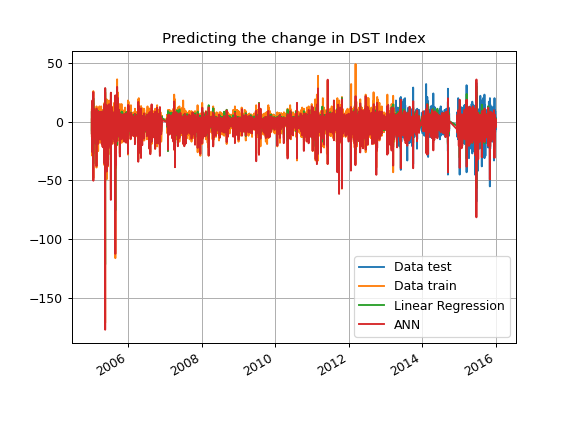

In [32]:
plt.figure()
plt.title('Predicting the change in DST Index')
plt.plot(t_test, y_test, label='Data test')
plt.plot(t_train, y_train, label='Data train')
for model in models:
    p = plt.plot(t_test, model['test_predict'], label=model['name'])
    # Plot another line with the same color
    plt.plot(t_train, model['train_predict'], color=p[0].get_color())
plt.legend()
plt.gcf().autofmt_xdate()
plt.grid(True)